*Author: Pooya Bagheri*               **UnderConstruction**

## 1 Creating objects for Incremental Loading
I have written a class called *DataGenerator* for incremental loading of data. The object from this class loads data for a day at once to avoid memory problems. We use this object to extend our training set to the first 22 days available in the dataset:

In [1]:
from IncrementalLoading import DataGenerator
from LoadingDataClass import MLinputData

MyDataGen=DataGenerator(1,22) #Data generator to incrementally load data for the first 22 days
#Creating iterator object for incremental data generation used by Keras training function:
BatchSize=144
DataGenIterator=MyDataGen.__iter__(BatchSize)

#Load and scale validation data:
validation=MLinputData(23,25) # Loading validation data (23rd to 25th day)
#Create a tuple including scaled validation data suitable for Keras:
validation_data=(MyDataGen.scaler_x.transform(validation.x),MyDataGen.scaler_y.transform(validation.y))

#Load and scale test data:
test=MLinputData(26,30) # Loading Test sets (last 5 of 30 days)
x_test=MyDataGen.scaler_x.transform(test.x)

## 2. Training ANN by incremental loading
We start the training on on a ANN network with similar structure to the last example in the [previous step](Step3-MLmodels-NeuralNetworks.ipynb):

In [2]:
import warnings
warnings.filterwarnings("ignore") #in order to avoid unnecessary warnings when loading Keras modules

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

#Defining structure of model
DataWidth=MyDataGen.xData.shape[1]
models=[None]*5
models[0]=Sequential()
models[0].add(Dense(DataWidth, input_dim=DataWidth,kernel_initializer='uniform',activation='relu'))
models[0].add(Dense(int(DataWidth/2), input_dim=DataWidth,kernel_initializer='uniform',activation='relu'))
models[0].add(Dense(1,input_dim=int(DataWidth/2),kernel_initializer='uniform',activation='linear'))
#Add checkpoint, compile and train the model
checkpoint = ModelCheckpoint("ANNweights2-0-best.hdf5", monitor='val_mean_squared_error', verbose=0, save_best_only=True, mode='min')
models[0].compile(optimizer='Adam' ,loss='mse',metrics=['mse'])


Using TensorFlow backend.


In [3]:
#Let's call Keras training function suitable for incremental loading:
LearningHistory=models[0].fit_generator(generator=DataGenIterator, steps_per_epoch=DataGenIterator.BatchPerDay*22, epochs=20, verbose=1, callbacks=[checkpoint], validation_data=validation_data, shuffle=True)

Epoch 1/20
31680/31680 [==============================] - 242s 8ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.1163 - val_mean_squared_error: 0.1163
Epoch 2/20
31680/31680 [==============================] - 246s 8ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0628 - val_mean_squared_error: 0.0628
Epoch 3/20
31680/31680 [==============================] - 248s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.1021 - val_mean_squared_error: 0.1021
Epoch 4/20
31680/31680 [==============================] - 263s 8ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0673 - val_mean_squared_error: 0.0673
Epoch 5/20
31680/31680 [==============================] - 290s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0703 - val_mean_squared_error: 0.0703
Epoch 6/20
31680/31680 [==============================] - 290s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.2064 - val_mean_squared_error:

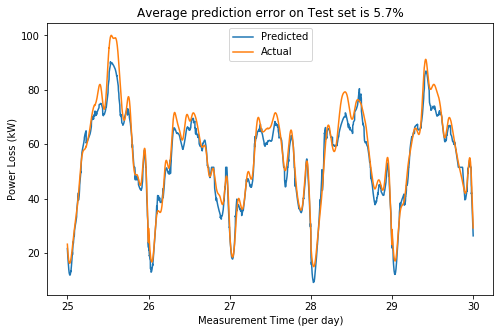

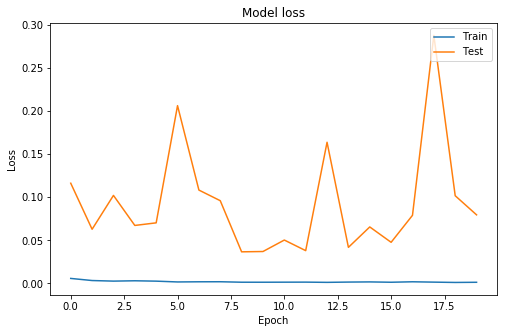

In [7]:
from MyPlotTools import Plot
Plt=Plot(FromDay=26,ToDay=30,plotHeight=5,plotWidth=8)
#Loading the best model from checkpoint and doing prediction on test:
models[0].load_weights("ANNweights2-0-best.hdf5")
y_predicted=MyDataGen.scaler_y.inverse_transform(models[0].predict(x_test))
Plt.AssessPrediction(y_predicted,test.y)
Plt.LearningCurve(LearningHistory)

We can even have a more complicated neural network to add to its flexibility to fit our data. Let's add two more hidden layers in the middle:

In [5]:
models[1]=Sequential()
models[1].add(Dense(DataWidth, input_dim=DataWidth,kernel_initializer='uniform',activation='relu')) #1st hidden layer
models[1].add(Dense(DataWidth, input_dim=DataWidth,kernel_initializer='uniform',activation='relu')) #2nd hidden layer
models[1].add(Dense(DataWidth, input_dim=DataWidth,kernel_initializer='uniform',activation='relu')) #3rd hidden layer
models[1].add(Dense(int(DataWidth/2), input_dim=DataWidth,kernel_initializer='uniform',activation='relu')) #4th hidden layer
models[1].add(Dense(1,input_dim=int(DataWidth/2),kernel_initializer='uniform',activation='linear')) #output layer
#Add checkpoint, compile and train the model
checkpoint = ModelCheckpoint("ANNweights2-1-best.hdf5", monitor='val_mean_squared_error', verbose=0, save_best_only=True, mode='min')
models[1].compile(optimizer='Adam' ,loss='mse',metrics=['mse'])

In [6]:
#Create a fresh new data generator:

#Let's call Keras training function suitable for incremental loading:
LearningHistory=models[1].fit_generator(generator=DataGenIterator, steps_per_epoch=DataGenIterator.BatchPerDay*22, epochs=20, verbose=1, callbacks=[checkpoint], validation_data=validation_data, shuffle=True)
DataGenIterator=MyDataGen.__iter__(BatchSize)

Epoch 1/20
31680/31680 [==============================] - 276s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.1431 - val_mean_squared_error: 0.1431
Epoch 2/20
 8628/31680 [=======>......................] - ETA: 3:00 - loss: 0.0046 - mean_squared_error: 0.0046

KeyboardInterrupt: 

In [ ]:
#Loading the best model from checkpoint and doing prediction on test:
models[1].load_weights("ANNweights2-1-best.hdf5")
y_predicted=MyDataGen.scaler_y.inverse_transform(models[1].predict(x_test))
Plt.AssessPrediction(y_predicted,test.y)
Plt.LearningCurve(LearningHistory)